Neural Networks workshop

# Workshop structure

*   In presentation we've already talked about
 *   History
 *   How it works:
     *  Neuron
     * Activation function
     * Loss function
     * Backpropagation
*  Now we will look how it works <- we are here
*  Later we'll be back at presentation and discuss about:
  - More "advanced" layers
  - Architectures and transfer learning



# Example of neural network implementation

We will go through tensorflow guide for neural network implementation to solve regression task using keras - https://www.tensorflow.org/tutorials/keras/regression

This notebook uses the classic Auto MPG Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.1


## Read data

Dataset available at [UCI](https://archive.ics.uci.edu/ml/index.php).  
And can be downloaded through keras API

In [ ]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [ ]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## Lets look at data

Some default EDA here

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


We can see that there are 6 NaN values un Horsepower column. We will drop them

In [ ]:
dataset = dataset.dropna()

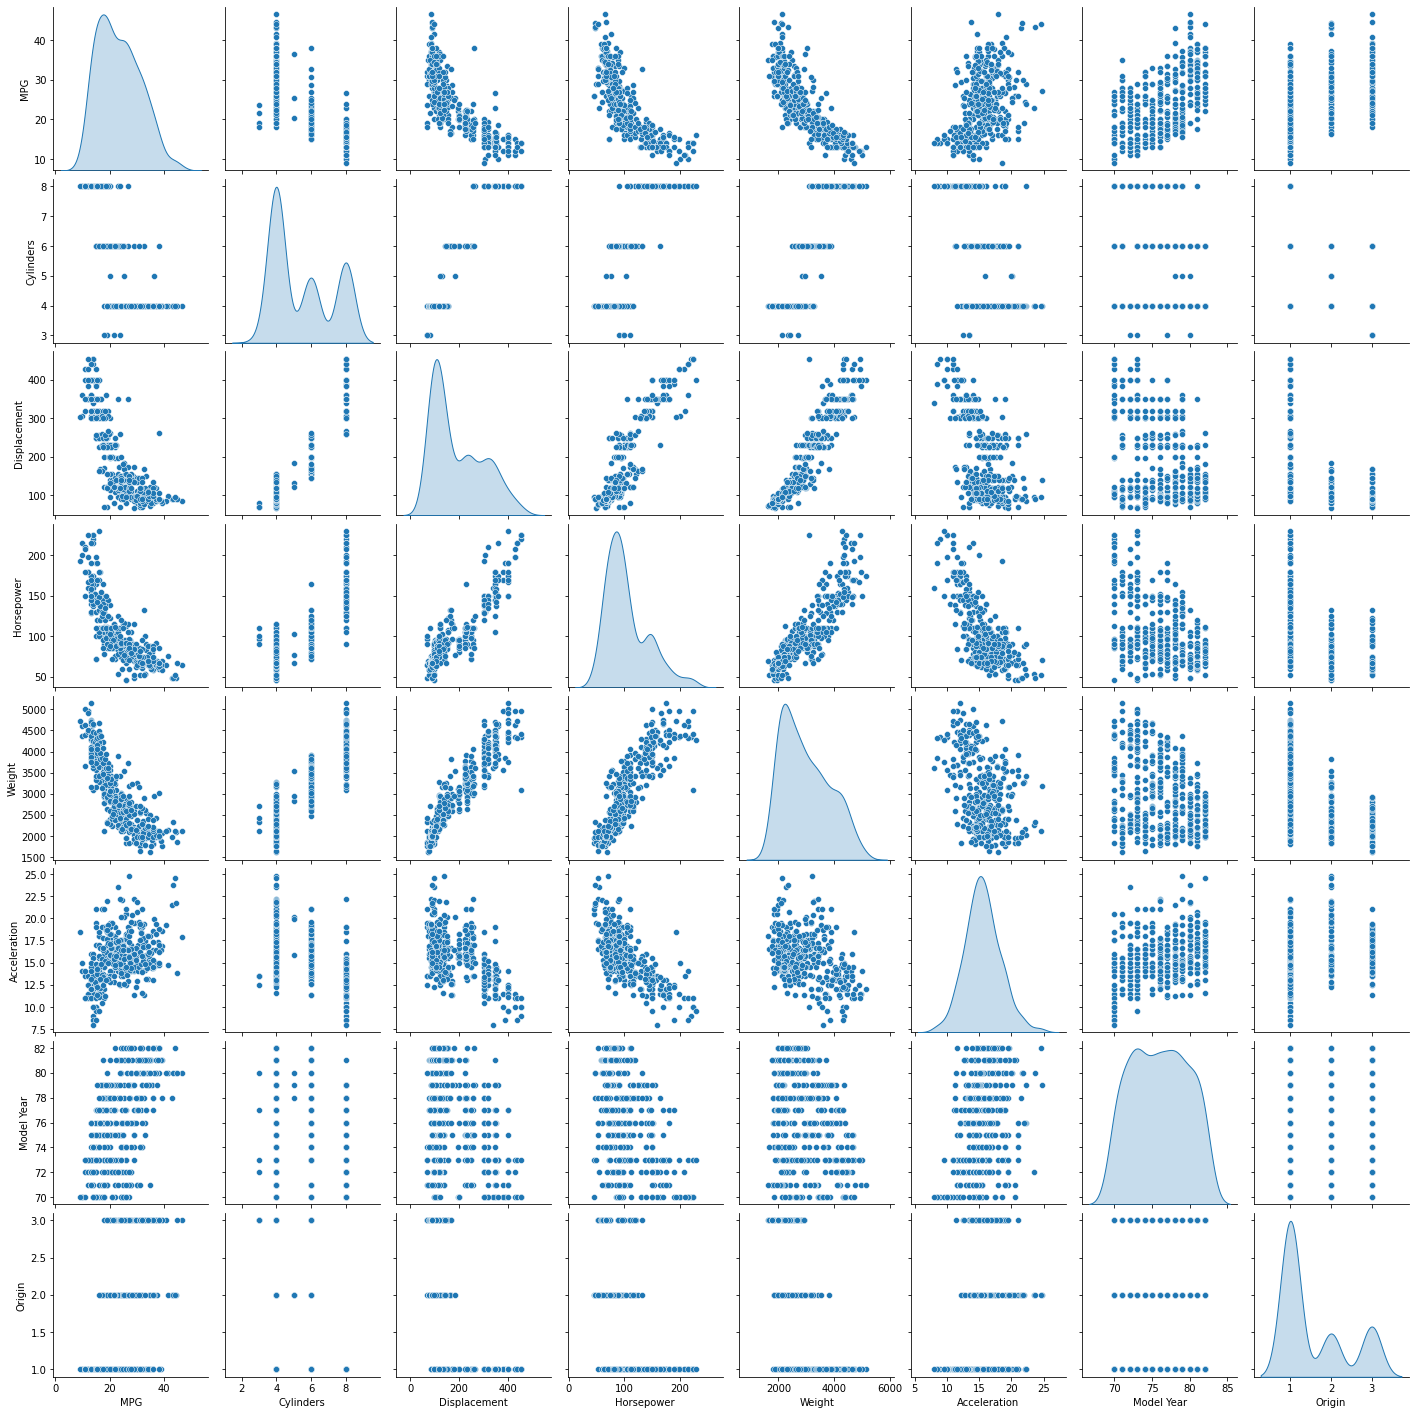

In [ ]:
sns.pairplot(dataset, diag_kind="kde")

We can see that there are couple categorical features (Cylinders & Origin). We will OHE them. Model year stored as integer values, but there is a lot of unique values.

In [ ]:
dataset['Origin'].nunique()

3

In [ ]:
dataset['Cylinders'].nunique()

5

In [ ]:
dataset['Model Year'].nunique()

13

In [ ]:
pd.get_dummies(dataset['Origin'], prefix='origin_')

,origin__1,origin__2,origin__3
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
393,1,0,0
394,0,1,0
395,1,0,0
396,1,0,0


In [ ]:
dataset_v2 = pd.concat([dataset, pd.get_dummies(dataset['Origin'], prefix='origin_')], axis=1)
dataset_v2.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,origin__1,origin__2,origin__3
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,1,0,0


In [ ]:
dataset_v3 = pd.concat([dataset_v2, pd.get_dummies(dataset['Cylinders'], prefix='cylinders_')], axis=1)
dataset_v3.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,origin__1,origin__2,origin__3,cylinders__3,cylinders__4,cylinders__5,cylinders__6,cylinders__8
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,1,0,0,0,0,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,1,0,0,0,0,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,1,0,0,0,0,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,1,0,0,0,0,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,1,0,0,0,0,0,0,1


In [ ]:
train_dataset = dataset_v3.sample(frac=0.8,random_state=0)
test_dataset = dataset_v3.drop(train_dataset.index)

In [ ]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [ ]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Origin,314.0,1.573248,0.800988,1.0,1.00,1.0,2.00,3.0
origin__1,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
origin__2,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
origin__3,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


## Data normalization

Usually neural networks can works without data normalization. But in most cases we may achieve speed increase at training phase

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## To the model

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.columns)]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1024      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

You can read about callbacks [here](https://keras.io/api/callbacks/). Most common are already implemented (and one of them we will see later)

## history - what it is

In [ ]:
hist = pd.DataFrame(history.history)
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse
0,563.642761,22.551678,563.642761,545.820923,22.121788,545.820923
1,498.075165,21.053080,498.075165,480.352234,20.642944,480.352234
2,434.993378,19.558517,434.993378,408.287384,18.901096,408.287384
3,365.305939,17.781406,365.305908,330.033539,16.828312,330.033539
4,292.176056,15.713488,292.176056,252.936493,14.477022,252.936493


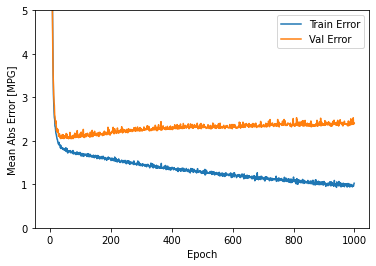

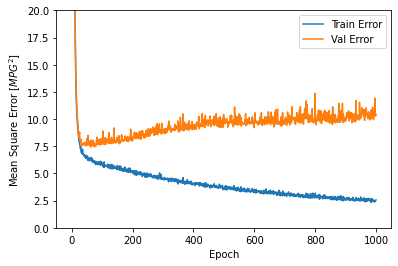

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

On history plot we my find out that there is a moment then our model loss stop decreasing (and it looks like as it start increasing). Probably we should stop our model earlier? How to do it? 

## ?


...........................................................................................

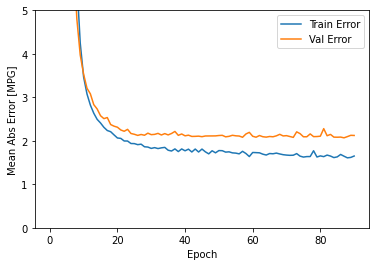

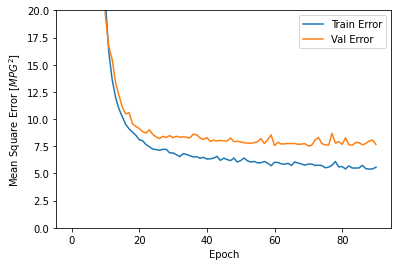

In [ ]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

Looks like number of dots decreased (and so does number of epochs on history plot). So our callback worked.

## What about test set?

Usually we want not only train our model :), but also check it performance on some subset of our data

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.5359 - mae: 1.7591 - mse: 5.5359
Testing set Mean Abs Error:  1.76 MPG


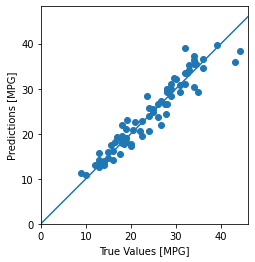

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

It looks like our model predicts something more or less correlated with true values :)

At this point we should run some default activities for investigation of our regression model performance but our main goal here is to look at neural network, so we will go further :)

# What about classification?

Let's think about what we should change to make model for classification task.   
As a reminder - our model in case of regression looked like this:

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.columns)]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

## answer is...

size and activation function of ouput layer, loss function, metrics

Good guide about how to work with classification task is [here](https://www.tensorflow.org/tutorials/keras/classification)

# And now we will go back to presentation

For more complicated cases (we looked only regression and classification at tabular data) we might need some more "advanced" layers. Now we will go back to presentation and talk a bit about some of them and how to use them